In [ ]:
!pip install transformers
# Standard libraries
import os
import json
import time
import logging
import random

# Third-party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import model_selection, feature_selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, roc_curve,
                             auc, f1_score, precision_score, recall_score)
import nltk
import torch
from torch.utils.data import Dataset, DataLoader
from torch import cuda
from transformers import RobertaModel, RobertaTokenizer

# Setup Logging
logging.basicConfig(level=logging.ERROR)

# GPU usage setup
device = 'cuda' if cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

# Seeding for reproducibility
random.seed(1)
np.random.seed(1)
torch.cuda.manual_seed(1)
torch.manual_seed(1)

# Download necessary data from nltk
nltk.download('punkt')
nltk.download('stopwords')

# Time tracking
start_time = time.time()

# Note: Ensure that you have already installed required packages like 'transformers'
# using pip in a separate cell or as a setup script.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# mount drive to access data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:

%cd /content/drive/MyDrive/nvdrs_narratives/round_1_annotation_topics

%ls

/content/drive/MyDrive/nvdrs_narratives/round_1_annotation_topics
 breakup_feature_contributions_plot.png
 breakup_feature_importance_plot.png
 breakup_lr_model.pkl
 breakup_sample_0_sd_completed.csv
 breakup_sampled_sd_completed.csv
 child_custody_loss_feature_contributions_plot.png
 child_custody_loss_feature_importance_plot.png
 child_custody_loss_lr_model.pkl
 child_feature_contributions_plot.png
 child_feature_importance_plot.png
 child_sample_0_sd_completed.csv
 child_sampled_dw_completed.csv
 divorce_feature_contributions_plot.png
 divorce_feature_importance_plot.png
 divorce_lr_model.pkl
 divorce_sample_0_dw_completed.csv
 divorce_sampled_sr_completed.csv
 eviction_feature_contributions_plot.png
 eviction_feature_importance_plot.png
 eviction_or_move_lr_model.pkl
'eviction or move_sample_0_sp_completed.csv'
'eviction or move_sampled_sp_completed.csv'
 nvdrs_breakup_model_results.csv
 nvdrs_breakup_model_results.gsheet
'nvdrs_child custody loss_model_results.csv'
 nvdrs_child_cu

# Read in dataset

In [ ]:
# Read in sentence tokenized MIMIC-III
nvdrs_raw = pd.read_csv("/content/drive/MyDrive/indexedData.csv", encoding='latin-1')
nvdrs_raw.head()
print(list(nvdrs_raw.columns))
regex_dataframe = pd.read_excel("/content/drive/MyDrive/nvdrs_narratives/final_combined_data.xlsx")
regex_dataframe["topic_name"].value_counts()
#Combined regex data-- this looks like all the regex combined final_combined_data.xlsx-- need to separate this by topic, then merge one by one

regex_dataframe
# Create new dataframe from regex_dataframe which will be used to eventually generate the topic-level dataframes, which we will merge into nvdrs_raw.
# Create new text field. If NarrativeCME or NarrativeLE is blank, input the column which is not of the two. If neither are NA, select the NarrativeLE if matched_term_x is not NA, and NarrativeCME if matched_term_y is not NA. If none are NA, pick NarrativeCME.
processed_df = pd.DataFrame()
for index, row in regex_dataframe.iterrows():
    if pd.isna(row['NarrativeCME']) and not pd.isna(row['NarrativeLE']):
        text = row['NarrativeLE']
    elif pd.isna(row['NarrativeLE']) and not pd.isna(row['NarrativeCME']):
        text = row['NarrativeCME']
    elif not pd.isna(row['NarrativeCME']) and not pd.isna(row['NarrativeLE']):
        if not pd.isna(row['matched_term_x']):
            text = row['NarrativeLE']
        elif not pd.isna(row['matched_term_y']):
            text = row['NarrativeCME']
        else:
            text = row['NarrativeCME']
    else:
        text = ""  # or some default value in case both narratives are NA

    processed_df = processed_df.append({'text': text, 'IncidentID': row['IncidentID'], 'topic_name': row['topic_name']}, ignore_index=True)

# Step 2: Select relevant fields
processed_df = processed_df[['text', 'IncidentID', 'topic_name']]

processed_df["topic_name"].value_counts()
# Separate this by topic, where we have resulting dataframes named for each topic.
# Step 3: Separate data by topic
topic_dfs = {}
for topic, group_df in processed_df.groupby('topic_name'):
    topic_dfs[topic] = group_df


processed_df["topic_name"].value_counts()


eviction or move    29767
divorce             15247
breakup             12269
child                5308
pet                  1351
social_isolation     1196
Name: topic_name, dtype: int64

# Split regex dataframe by topic

## Predict on each dataframe using models



In [ ]:
import pickle

# Paths to the model files
model_paths = {
    'breakup': '/content/drive/MyDrive/nvdrs_narratives/round_1_annotation_topics/breakup_lr_model.pkl',
    'child': '/content/drive/MyDrive/nvdrs_narratives/round_1_annotation_topics/child_custody_loss_lr_model.pkl',
    'divorce': '/content/drive/MyDrive/nvdrs_narratives/round_1_annotation_topics/divorce_lr_model.pkl',
    'pet': '/content/drive/MyDrive/nvdrs_narratives/round_1_annotation_topics/pet_loss_lr_model.pkl',
    'social_isolation': '/content/drive/MyDrive/nvdrs_narratives/round_1_annotation_topics/social_isolation_rf_model.pkl',
    'eviction or move': '/content/drive/MyDrive/nvdrs_narratives/round_1_annotation_topics/eviction_or_move_lr_model.pkl'
}

# Load models
models = {}
for topic, path in model_paths.items():
    with open(path, 'rb') as file:
        models[topic] = pickle.load(file)

In [ ]:
# apply_predictions function, applies predictions for each topic model, adds predictions column specific to that topic
def apply_predictions(df, model, vectorizer, topic):
    # Transform text data using the provided vectorizer
    transformed_text = vectorizer.transform(df['text'])

    # Make predictions using the provided model
    predictions = model.predict(transformed_text)

    # Add predictions to the DataFrame with a column named as 'topic_prediction'
    prediction_column_name = f"{topic}_prediction"
    df[prediction_column_name] = predictions
    return df
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000, stop_words="english")

# Fit the vectorizer on the entire dataset (assuming this is the correct approach)
# Note: This should be done once, and the same vectorizer should be used for all topics
vectorizer.fit(processed_df['text'])

# Apply predictions for each topic
for topic, df in topic_dfs.items():
    if topic in models:
        model = models[topic]
        topic_dfs[topic] = apply_predictions(df, model, vectorizer, topic)
    else:
        print(f"No model found for topic: {topic}")



In [ ]:
# Initialize nvdrs_merged with nvdrs_raw to preserve the original DataFrame
nvdrs_merged = nvdrs_raw.copy()

# Step 5: Sequentially add prediction columns for each topic into nvdrs_merged
for topic, df in topic_dfs.items():
    # Ensure the correct prediction column name is used
    prediction_column_name = f"{topic}_prediction"
    if 'prediction' in df.columns:
        df = df.rename(columns={'prediction': prediction_column_name})

    # Merge the topic-specific prediction column into nvdrs_merged
    # Using suffixes to handle overlapping columns
    nvdrs_merged = nvdrs_merged.merge(df[['IncidentID', 'topic_name', prediction_column_name]], on='IncidentID', how='left', suffixes=('', f'_{topic}'))


# Identify suffixed topic_name columns
suffixed_topic_columns = [col for col in nvdrs_merged.columns if col.startswith('topic_name_')]

# Replace topic names with "1" and other values with "0"
for col in suffixed_topic_columns:
    # The topic is the part of the column name after 'topic_name_'
    topic = col.split('topic_name_')[1]
    nvdrs_merged[col] = nvdrs_merged[col].apply(lambda x: 1 if x == topic else 0)

nvdrs_merged['topic_name'].value_counts()
nvdrs_merged['IncidentID'].nunique()

# Identify columns ending with _prediction
prediction_columns = [col for col in nvdrs_merged.columns if col.endswith('_prediction')]

# Fill NaN values with 0s in each prediction column
for col in prediction_columns:
    nvdrs_merged[col] = nvdrs_merged[col].fillna(0)

nvdrs_merged
# Create a new column 'topic_name_breakup' with binary values
nvdrs_merged['topic_name_breakup'] = (nvdrs_merged['topic_name'] == 'breakup').astype(int)


In [ ]:
nvdrs_merged.columns

# List all columns in nvdrs_merged that have "prediction" in their names
# Identify columns with suffix 'topic_name_' and columns ending with '_prediction'
suffixed_topic_columns = [col for col in nvdrs_merged.columns if col.startswith('topic_name_')]
prediction_columns = [col for col in nvdrs_merged.columns if col.endswith('_prediction')]

# Calculate value counts for each relevant column
value_counts_data = {}

# Value counts for suffixed topic_name columns
for col in suffixed_topic_columns:
    value_counts_data[col] = nvdrs_merged[col].value_counts()

# Value counts for prediction columns
for col in prediction_columns:
    value_counts_data[col] = nvdrs_merged[col].value_counts()

# Print or use value_counts_data as needed
print(value_counts_data)

{'topic_name_child': 0    301491
1      5326
Name: topic_name_child, dtype: int64, 'topic_name_divorce': 0    291486
1     15331
Name: topic_name_divorce, dtype: int64, 'topic_name_eviction or move': 0    276840
1     29977
Name: topic_name_eviction or move, dtype: int64, 'topic_name_pet': 0    305450
1      1367
Name: topic_name_pet, dtype: int64, 'topic_name_social_isolation': 0    305619
1      1198
Name: topic_name_social_isolation, dtype: int64, 'topic_name_breakup': 0    294506
1     12311
Name: topic_name_breakup, dtype: int64, 'breakup_prediction': 0.0    294506
1.0     12311
Name: breakup_prediction, dtype: int64, 'child_prediction': 0.0    305586
1.0      1231
Name: child_prediction, dtype: int64, 'divorce_prediction': 0.0    291486
1.0     15331
Name: divorce_prediction, dtype: int64, 'eviction or move_prediction': 0.0    297349
1.0      9468
Name: eviction or move_prediction, dtype: int64, 'pet_prediction': 0.0    306817
Name: pet_prediction, dtype: int64, 'social_isolation

In [ ]:
nvdrs_merged.to_csv("nvdrs_merged_with_predictions.csv")

# EDA, Distributions


In [ ]:
topics = ['breakup', 'child', 'divorce', 'pet', 'social_isolation', 'eviction or move']
frequency_data = {}

for topic in topics:
    prediction_column_name = f"{topic}_prediction"
    if prediction_column_name in nvdrs_merged.columns:
        frequency_data[topic] = nvdrs_merged[prediction_column_name].value_counts()

# Print or store frequency_data as needed
print(frequency_data)

{'breakup': 1.0    12311
Name: breakup_prediction, dtype: int64, 'child': 0.0    4095
1.0    1231
Name: child_prediction, dtype: int64, 'divorce': 1.0    15331
Name: divorce_prediction, dtype: int64, 'pet': 0.0    1367
Name: pet_prediction, dtype: int64, 'social_isolation': 1.0    1198
Name: social_isolation_prediction, dtype: int64, 'eviction or move': 0.0    20509
1.0     9468
Name: eviction or move_prediction, dtype: int64}


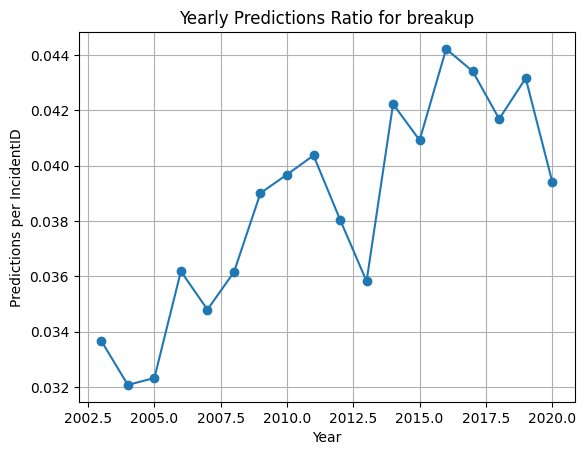

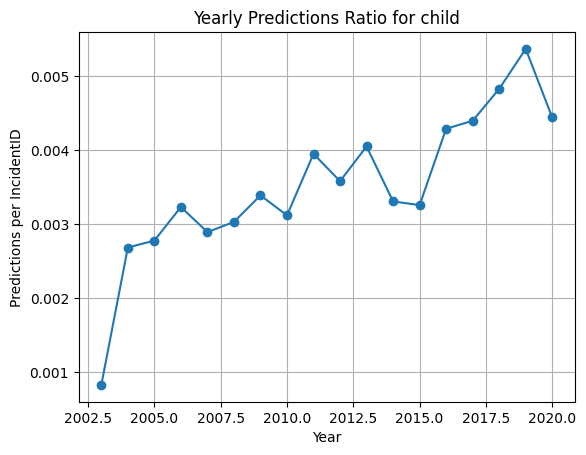

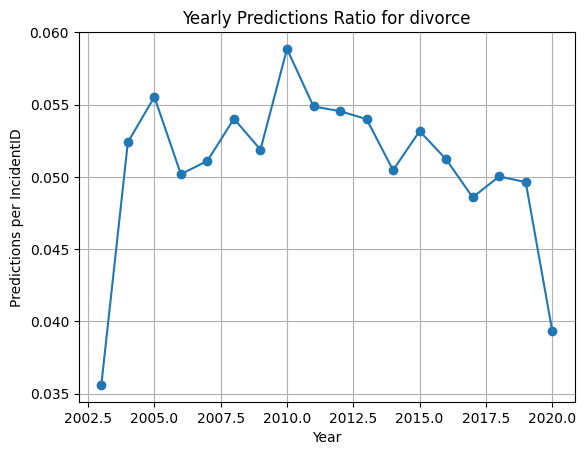

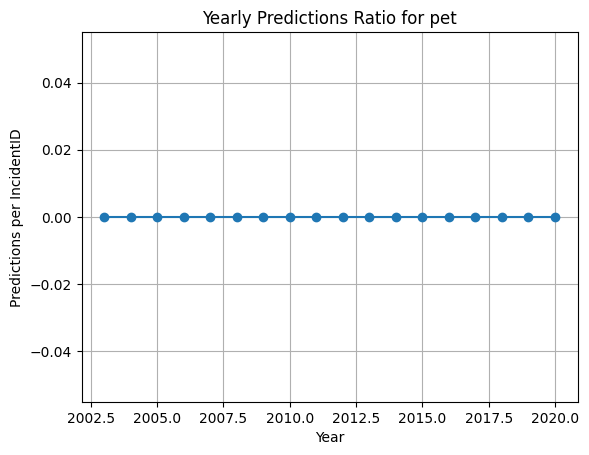

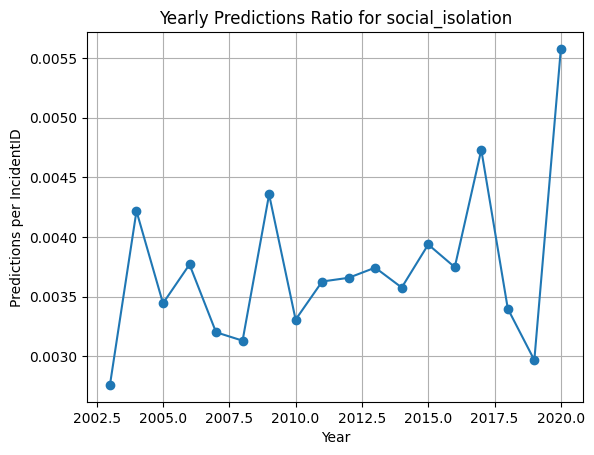

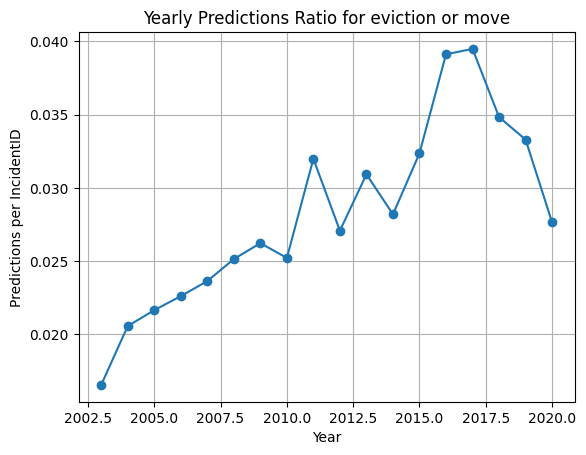

In [ ]:
import matplotlib.pyplot as plt

# Assuming there's a date column 'IncidentDate' from which to extract the year

for topic in topics:
    prediction_column_name = f"{topic}_prediction"
    if prediction_column_name in nvdrs_merged.columns:
        # Calculate yearly predictions and total IncidentID counts
        yearly_data = nvdrs_merged.groupby('IncidentYear').agg({
            prediction_column_name: 'sum',
            'IncidentID': 'count'
        })

        # Calculate the ratio of predictions per total IncidentID
        yearly_data['Prediction_Ratio'] = yearly_data[prediction_column_name] / yearly_data['IncidentID']

        # Plotting the yearly line graph
        plt.figure()
        plt.plot(yearly_data.index, yearly_data['Prediction_Ratio'], marker='o')
        plt.title(f'Yearly Predictions Ratio for {topic}')
        plt.xlabel('Year')
        plt.ylabel('Predictions per IncidentID')
        plt.grid(True)
        plt.show()


## Sample characteristics